# Inverse Modeling of Ocean IOPs from Remote Sensing

#### This code works through a nonlinear least squares remote sensing reflectance inversion from Roesler & Perry 1995.

Written in Matlab July 2021 by C. Roesler based on her paper "In situ phytoplankton absorption, fluorescence emission, and particulate backscattering spectra determined from reflectance" https://doi.org/10.1029/95JC00455

Ported to python by Patrick C. Gray August 2021 from matlab written by Collin Roesler

##### inputs:
       mod   = select model type (number and character of eigenvectors)  
       R     = measured reflectance spectrum  
       wave  = wavelength array  
       a_ph  = phytoplankton eigenvector  
       a_cdm = detrital eigenvector (slope = -0.01 nm^-1)  
       a_nap = non-algal particle eigenvector (slope = -0.01 nm^-1)  
       a_cdom= colored dissolved organic matter eigenvector (slope = -0.02 nm^-1)  
       bb_p  = single particle backscattering spectrum eigenvector (eta = -0.75)  
       bb_s  = small particle backscattering spectrum eigenvector (eta = -1)  
       bb_l  = large particle backscattering spectrum eigenvector (eta = 0)  
       Temp  = in situ water temperature (oC)  
       Sal   = in situ water salinity (ppt)  
##### outputs:
       eigenvalues associated with each eigenvector  
       aph   = phytoplankton eigenvalue  
       acdm  = non-algal particle eigenvalue   
       anap  = non-algal particle eigenvalue   
       acdom = colored dissolved organic matter eigenvalue  
       bbp   = single particle backscattering spectrum eigenvalue  
       bbs   = small particle backscattering spectrum eigenvalue  
       bbl   = large particle backscattering spectrum eigenvalue  


#### Notes
* load the data file (this can certainly be modified to load your own data set, 
* just make sure it has similar format
* note these data files are named R_E_... or R_L_... to indicate irradiance reflectance (Eu/Ed) or radiance reflectance (Lu/Ed). 
* These data sets are measured/simulated with upward light (Lu or Eu) measured/modeled just below the air water interface. Those from above-water measurements will account for the interface in the f/Q values.

TODOs
- fix all errors (questions) and compare with different models
- calculate RMS function the excludes trhe fluoresence peak
- it probably does need bounds bc it can go negative otherwise
- update endmember with a lab based phytoplankton spec that is newer
- add in a constant flat line bc NAP doesn't actually go to zero

- Notes on normalizing IOPs
  - you can normalize to chla if you have the measurement or you can normalize to absorption at a specific wavelength
- you could cut the fluoresence wavelengths out of the fit model OR just add fluoresence as an endmember

#### Bring in all the necessary packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy import interpolate
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import least_squares
import math
from sklearn.metrics import mean_squared_error

#### Start running the code asking for input from the user

In [ ]:
print("""Enter number in parenthesis to select data sets:
(1) Oregon Coast
(2) Puget Sound
(3) Dabob Bay
(4) Gulf of Maine
(5) Hydrolight simulation
(6) Harpswell ap spectra""")
d=input('number  ');

d = int(d)

if d==1:
    R = np.genfromtxt('data/R_E_OregonCoast.csv', delimiter=',')
    wavelength = np.genfromtxt('data/R_E_OregonCoast_wavelength.csv', delimiter=',')
elif d==2: 
    R = np.genfromtxt('data/R_E_PugetSound.csv', delimiter=',')
    wavelength = np.genfromtxt('data/R_E_PugetSound_wavelength.csv', delimiter=',')
elif d==3:
    R = np.genfromtxt('data/R_E_DabobBay.csv', delimiter=',')
    wavelength = np.genfromtxt('data/R_E_DabobBay_wavelength.csv', delimiter=',')
elif d==4:
    R = np.genfromtxt('data/R_E_GulfMaine.csv', delimiter=',')
    wavelength = np.genfromtxt('data/R_E_GulfMaine_wavelength.csv', delimiter=',')
elif d==5:
    R = np.genfromtxt('data/R_L_HLsimulation.csv', delimiter=',')
    wavelength = np.genfromtxt('data/R_L_HLsimulation_wavelength.csv', delimiter=',')
elif d==6:
    wavelength = pd.read_csv('data/acs_wavelength.csv',header=None).values[0]
    acs_part_bin = pd.read_csv('data/ACS94_20210804_prod_p.csv').iloc[:,1:82].to_numpy()
    where_are_NaNs = np.isnan(acs_part_bin)
    acs_part_bin[where_are_NaNs] = 0
    R = acs_part_bin.T
    R = R[:,:40]
    
# nR here is the number of spectra we have in this sample, each will be fitted individually
nR=R.shape[1]

W=input('enter (1) for full spectral resolution, or (2) for MODIS wavelengths    ')
W = int(W)
if W==2:
    mw=[412,443,465.5,531,551,667,678,748,869.5]
    Ri = []
    for i in range(nR):
        fx = InterpolatedUnivariateSpline(wavelength,R[:,i], k=1) # a linear spline interpolator
        Ri.append(fx(mw)) #interpolate to MODIS wavelengths
    Ri = np.array(Ri)
    # not doing this right now
    #Ri=np.vstack((np.array(mw), np.array(Ri))) # add the wavelengths on as the top row
    #Ri=denan(Ri); #remove wavelengths where there was no data
    wavelength=np.array(mw)
    R=Ri.T
if R.shape[1]>1000:
    plt.plot(wavelength, R[:,10000:10010])
else:
    plt.plot(wavelength, R)
plt.title('Measured spectra')
plt.ylabel('R(lambda)')
plt.xlabel('Wavelength(nm)')
plt.show()

#### Enter the f/Q and the model you'd like to use. 

This block also specifies many of the eigenvector parameters and then defines the eigenvectors.

In [ ]:
# fQ corrects for the angular distribution of measurements, corrects for the angle of one measurement to another, corrects to nadir

fQ=input('enter f/Q for the data set (e.g.,0.33 for Eu/Ed, 0.09 for Lu/Ed or your observations   ')
fQ = float(fQ)
mod=input('enter model number 1 through 8 (see handout for details or read @fun coding lines )   ')
mod = int(mod)

# Define eigenvectors parameters (these are meant to represent ranges, you
# may want to modify them (e.g., Snap to -0.007?)
Scdm  = -0.0145     # exponential slope of combined cdom and nap absorption
Snap  = -0.01       # exponential slope of nap absorption
Scdom = -0.02       # exponential slope of cdom absorption
Sbbp  = 0.75        # power law exponent for particulate backscattering (from Boss et al. 2013)
Sbbs  = 1           # power law exponent for particulate backscattering small particle endmember
Sbbl  =  0          # power law exponent for particulate backscattering large particle endmember
Temp  = 18          # in situ seawater temperature
Sal   = 31          # in situ seawater salinity
RefLambda=440       # reference wavelength for analytic functions for anap, acdom, bbp

# Define eigenvectors
I = np.argwhere(wavelength>=RefLambda-2.5) #find wavelength closest to desired reference wavelength (+/- 2.5)
Lref=wavelength[I[0]]

#### We now define some functions that create the seawater a and b spectra based on measured salinty and temperature values as well as a few helper functions for pulling in measured phytoplankton spectra.

In [ ]:
def water_iops_PF_TScorr(wave,T,S):
    # function to obtain seawater absorption and backscattering spectra
    # pure water absorption from Pope and Frye
    # pure water backscattering from Morel
    # corrected for in situ temperature and salinity conditions

    # TODO ask collin this is greater than 730 because 
    #if min(wave)<380 or max(wave)>730:
    if min(wave<380) or max(wave)>900:
        raise ValueError('input wavelengths  are beyond acceptable range')
    else:
        #Pope and Frye pure water absorption 380-730 nm, then Smith and Baker 730-800 nm
        wl_water =np.array([380,382.5,385,387.5,390,392.5,395,397.5,400,402.5,405,407.5,410,412.5,415,417.5,420,422.5,425,427.5,430,432.5,435,437.5,440,442.5,445,447.5,450,452.5,455,457.5,460,462.5,465,467.5,470,472.5,475,477.5,480,482.5,485,487.5,490,492.5,495,497.5,500,502.5,505,507.5,510,512.5,515,517.5,520,522.5,525,527.5,530,532.5,535,537.5,540,542.5,545,547.5,550,552.5,555,557.5,560,562.5,565,567.5,570,572.5,575,577.5,580,582.5,585,587.5,590,592.5,595,597.5,600,602.5,605,607.5,610,612.5,615,617.5,620,622.5,625,627.5,630,632.5,635,637.5,640,642.5,645,647.5,650,652.5,655,657.5,660,662.5,665,667.5,670,672.5,675,677.5,680,682.5,685,687.5,690,692.5,695,697.5,700,702.5,705,707.5,710,712.5,715,717.5,720,722.5,725,727.5,730,732.5,735.0,737.5,740.0,742.5,745.0,747.5,750.0,752.5,755.0,757.5,760.0,762.5,765.0,767.5,770.0,772.5,775.0,777.5,780.0,782.5,785.0,787.5,790.0,792.5,795.0,797.5,800.0])
        a_water  =np.array([0.01137,0.010044,0.00941,0.00917,0.00851,0.00829,0.00813,0.00775,0.00663,0.00579,0.0053,0.00503,0.00473,0.00452,0.00444,0.00442,0.00454,0.00474,0.00478,0.00482,0.00495,0.00504,0.0053,0.0058,0.00635,0.00696,0.00751,0.0083,0.00922,0.00969,0.00962,0.00957,0.00979,0.01005,0.01011,0.0102,0.0106,0.0109,0.0114,0.0121,0.0127,0.0131,0.0136,0.0144,0.015,0.0162,0.0173,0.0191,0.0204,0.0228,0.0256,0.028,0.0325,0.0372,0.0396,0.0399,0.0409,0.0416,0.0417,0.0428,0.0434,0.0447,0.0452,0.0466,0.0474,0.0489,0.0511,0.0537,0.0565,0.0593,0.0596,0.0606,0.0619,0.064,0.0642,0.0672,0.0695,0.0733,0.0772,0.0836,0.0896,0.0989,0.11,0.122,0.1351,0.1516,0.1672,0.1925,0.2224,0.247,0.2577,0.2629,0.2644,0.2665,0.2678,0.2707,0.2755,0.281,0.2834,0.2904,0.2916,0.2995,0.3012,0.3077,0.3108,0.322,0.325,0.335,0.34,0.358,0.371,0.393,0.41,0.424,0.429,0.436,0.439,0.448,0.448,0.461,0.465,0.478,0.486,0.502,0.516,0.538,0.559,0.592,0.624,0.663,0.704,0.756,0.827,0.914,1.007,1.119,1.231,1.356,1.489,1.678,1.7845,1.9333,2.0822,2.2311,2.3800,2.4025,2.4250,2.4475,2.4700,2.4900,2.5100,2.5300,2.5500,2.5400,2.5300,2.5200,2.5100,2.4725,2.4350,2.3975,2.3600,2.3100,2.2600,2.2100,2.1600,2.1375,2.1150,2.0925,2.0700])
        fx       = InterpolatedUnivariateSpline(wl_water,a_water, k=1) # a linear spline interpolator
        a_pw     = fx(wave)

        #Morel water backscattering
        #wl_b=[380  390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 750];
        #b_water=[0.0073    0.0066  0.0058  0.0052  0.0047  0.0043  0.0039  0.0035  0.0032  0.0029  0.0027  0.0024  0.0022  0.002   0.0018  0.0017  0.0016  0.0015  0.0013  0.0013  0.0012  0.0011  0.00101 0.00094 0.00088 0.00082 0.00076 0.00071 0.00067 0.00063 0.00059 0.00055 0.00052 0.0005];
        #%choose pure water scattering function (divide by two for back-scattering):
        #bb_pw=0.5*interp1(wl_b,b_water,wl,'linear');

        #log fit water backscattering
        bb_logfit=.0037000*(380**4.3)/(wave**4.3);

        #salinity correct:
        if S>0:
            bb_sw=((1+0.01*S)*bb_logfit)
        else:
            bb_sw=bb_logfit

        #temp and salinity correction for water absorption (need to know at what T it was measured): 
        if S==0:
            S=35
        if T==0:
            T=22
        T_pope=22.0

        #parameters for temp and salinity callibration (From Pegau et al Applied optics 1997):
        M=np.array([.18, .17, .52, 1.4, 4.6, 2.1, 4.3, 9.6, 1.6, 34, 18, 42])
        sig=np.array([18, 15, 14, 20, 17.5, 15, 17, 22, 6, 18, 20, 25])
        lamda_c=np.array([453, 485, 517, 558, 610, 638, 661, 697, 740, 744, 775, 795])
        M_T=np.array([0.0045,0.002,0.0045,0.002,0.0045,-0.004,0.002,-0.001,0.0045,0.0062,-0.001,-0.001])

        #computing the correction per degree C
#         phi_T = []
#         for i in range(len(wave)):
#             phi_T.append(M_T*M/sig*np.exp(-(wave[i]-lamda_c)**2/2/sig**2))
#         phi_T = np.array(phi_T)

        phi_T = []
        for i in range(len(wave)):
            sum_list = []
            for j in range(len(M)):
                sum_list.append(M_T[j]*M[j]/sig[j]*math.exp(-(wave[i]-lamda_c[j])**2/2/sig[j]**2))
            phi_T.append(sum(sum_list))
        phi_T = np.array(phi_T)
        
        #salinity correction based on Pegau and Zaneveld 1997:
        wls=np.array([412, 440, 488, 510, 532, 555, 650, 676, 715, 750])
        phi_S_PZ=np.array([0.00012,-0.00002,-0.00002,-0.00002,-0.00003,-0.00003,0,-0.00002,-0.00027,0.00064])

        #interpolate to compute salinity correction per psu
        # TODO ask Collin this is actually beyond the limits
        fx = InterpolatedUnivariateSpline(wls,phi_S_PZ, k=1) # a linear spline interpolator
        phi_S   = fx(wave)

        #temperature and salinity corrections:
        a_sw=(a_pw+phi_T.T*(T-T_pope)+phi_S*S)

        return(a_sw, bb_sw)

In [ ]:
def phyto_avg_abs(wavelength):
    # averaged spectrum from Roesler et al. 1989
    # scaled to specific absorption coefficient 0.0145 m2/mg at 676nm
    wl=np.arange(310,851,1)
    wl=wl.T
    a_f = np.genfromtxt('data/phyto_avg_abs.csv')
    fx = InterpolatedUnivariateSpline(wl,a_f, k=1)
    # TODO ask Collin why 1.25, probably ref index?
    a_phi=fx(wavelength)/1.25
    return(a_phi)

In [ ]:
def diat_dino_abs(wavelength):
    # averaged spectrum from Roesler (WET Cal experiment)
    # specific absorption coefficient (m2/mg)
    
    # take the file and interpolate the two different components about then merge them back
    a_f = np.genfromtxt('data/diat_dino_abs.csv')
    fx = InterpolatedUnivariateSpline(a_f[:,0],a_f[:,1], k=1)
    a_phi2_1 = fx(wavelength)
    fx = InterpolatedUnivariateSpline(a_f[:-1,0],a_f[:-1,2], k=1)
    a_phi2_2 = fx(wavelength)
    a_phi2 = np.array([a_phi2_1, a_phi2_2])
    return(a_phi2)

In [ ]:
def phyto_species_abs(wavelength):
    # averaged spectrum from Roesler (WET Cal experiment)
    # specific absorption coefficient (m2/mg)
    # dinoflagellate diatom chlorophyte cryptomonad
    
    # take the file and interpolate the different components about then merge them back
    a_f = np.genfromtxt('data/phyto_species_abs.csv', delimiter=',')
    
    a_phis = np.array([])
    
    for i in range(1,5):
        fx = InterpolatedUnivariateSpline(a_f[:,0],a_f[:,i], k=1)
        a_phix = fx(wavelength)
        # set wavelengths above 700 to 0
        a_phix[wavelength > 700] = 0
        if len(a_phis) == 0:
            a_phis = a_phix
        else:
            a_phis = np.vstack([a_phis,a_phix])
        
    return(a_phis)

#### Use all of these parameters and data based spectra to create the absorption and backscattering vectors at the correct wavelengths.

In [ ]:
# water basis vectors require temperature T and salinity S, output water IOPs at wave resolution
[a_w,bb_w]= water_iops_PF_TScorr(wavelength,Temp,Sal) # input temperature and salinity
bb_p      = ((Lref*np.ones(len(wavelength)) / wavelength)**Sbbp)
bb_s      = ((Lref*np.ones(len(wavelength)) / wavelength)**Sbbs)
bb_l      = ((Lref*np.ones(len(wavelength)) / wavelength)**Sbbl)
a_cdm     = np.exp(Scdm *(wavelength-Lref*np.ones(len(wavelength))))
a_nap     = np.exp(Snap *(wavelength-Lref*np.ones(len(wavelength))))
a_cdom    = np.exp(Scdom*(wavelength-Lref*np.ones(len(wavelength))))
a_ph1     = phyto_avg_abs(wavelength) #one component of chl-specific absorption
a_ph2     = diat_dino_abs(wavelength) #two components of chl-specific absorption (diat dino)

plt.plot(wavelength,a_w, label='water')
plt.plot(wavelength,a_cdm, label='CDOM+NAP')
plt.plot(wavelength,a_nap, label='NAP')
plt.plot(wavelength,a_cdom, label='CDOM')
plt.plot(wavelength,100*a_ph1, label='aphyt')
plt.plot(wavelength,100*a_ph2[0], label='adiatom')
plt.plot(wavelength,100*a_ph2[1], label='adino')

plt.legend()
plt.title("eigenvectors (spectra) of each absorbing endmember")
# plt.savefig('eigenvectors_for_a.png',dpi=300)
plt.show()

In [ ]:
# four components of chl-specific absorption: diat dino chlorophyte cryptomonad

# note that the measurements for these absorption spectra didn't extend beyond 700 so those wavelengths have been set to zero
a_phi_species = phyto_species_abs(wavelength)
labels = ['diatom', 'dinoflagellete', 'chlorophyte', 'cryptomonad']

for i in range(len(a_phi_species)):
    plt.plot(wavelength,a_phi_species[i], label=labels[i])

plt.legend()
plt.title("eigenvectors (spectra) for phyto species endmember")
# plt.savefig('additional_species.png',dpi=300)
plt.show()

In [ ]:
plt.plot(wavelength,bb_w, label='water')
plt.plot(wavelength,bb_p*.01, label='particles')
plt.plot(wavelength,bb_l*.01, label='small particles')
plt.plot(wavelength,bb_s*.01, label='large particles')
plt.legend()
plt.title("eigenvectors (spectra) of each scattering endmember")
# plt.savefig('scatterers.png',dpi=300)
plt.show()

#### Define the models and the first guesses on eigenvalues and their bounds

#### Now with all of this set up, run the least squares minimization and get the eigenvalues (aka the concentrations) of each component.

In [ ]:
def get_eigenvectors_through_minimization(R, mod, plot=True):
    # the estimated eigenvalues are in the array x, the order determined by
    # which model you select. Note that the phytoplankton absorption
    # eigenvectors (basis vectors) are chl-specific so the associated x-values
    # are chl (mg/m3). That is because those vectors were normalized to chla.
    
    ### input
    # R reflectance spectra
    # nR the number of input spectra
    # mod model chosen
    # plot whether or not to plot it
    ###
    ### output
    # x - estimated eigenvalues
    # rhat_list - estimated spectra from multiplying eigenvectors by eigenvalues
    # head - the labels for the eigenvalues being estimated
    # rms - rms for each spectra
    
    x = []
    rms = []
    rhat_list = []
    
    # step 1. Define the models (number and type of eigenvectors)
    # the math in each of these functions just multiplies the eigenvalues M (e.g. chla 
    # concentration, backscattering coefficient) by the eigenvectors to attempt to recreate 
    # the observed spectrum
    
    # assumption here (through the QSSA?) is that bb/a is equal to Rrs
    # so with these functions we subtract the actual Rrs from bb/a and then minimize this result
    def fun1(M):
        # 1 bbp, avg ph, acdm
        modeled_spectrum = fQ*(bb_w + M[0]*bb_p)/(a_w + M[1]*a_ph1 + M[2]*a_cdm )
        return(modeled_spectrum-R[:,i]) 
    def fun2(M):
        # 1 bbp, diat dino, acdm
        modeled_spectrum = fQ*(bb_w + M[0]*bb_p)/(a_w + M[1]*a_ph2[0] + M[2]*a_ph2[1] + M[3]*a_cdm )
        return(modeled_spectrum-R[:,i]) 
    def fun3(M):
        #1 bbp,1 phyt, nap, cdom
        modeled_spectrum = fQ*(bb_w + M[0]*bb_p)/(a_w + M[1]*a_ph1 + M[2]*a_nap  + M[3]*a_cdom )
        return(modeled_spectrum-R[:,i])
    def fun4(M):
        #1 bbp, 2 phyt, nap, cdom
        modeled_spectrum = fQ*(bb_w + M[0]*bb_p)/(a_w + M[1]*a_ph2[0] + M[2]*a_ph2[1] + M[3]*a_nap  + M[4]*a_cdom )
        return(modeled_spectrum-R[:,i])
    def fun5(M):
        #2 bbp, 1 ph, acdm
        modeled_spectrum = fQ*(bb_w + M[0]*bb_l + M[1]*bb_s)/(a_w + M[2]*a_ph1 + M[3]*a_cdm )
        return(modeled_spectrum-R[:,i])
    def fun6(M):
        # 2 bbp, 2 phyt, acdm
        modeled_spectrum = fQ*(bb_w + M[0]*bb_l + M[1]*bb_s)/(a_w + M[2]*a_ph2[0] + M[3]*a_ph2[1] + M[4]*a_cdm )
        return(modeled_spectrum-R[:,i])
    def fun7(M):
        # 2 bbp,1 phyt, nap, cdom
        modeled_spectrum = fQ*(bb_w + M[0]*bb_l + M[1]*bb_s)/(a_w + M[2]*a_ph1 + M[3]*a_nap  + M[4]*a_cdom )
        return(modeled_spectrum-R[:,i])
    def fun8(M):
        # 2 bbp, 2 phyt, nap, cdom
        modeled_spectrum = fQ*(bb_w + M[0]*bb_l + M[1]*bb_s)/(a_w + M[2]*a_ph2[2] + M[3]*a_ph2[1] + M[4]*a_nap  + M[5]*a_cdom )
        return(modeled_spectrum-R[:,i])
    def fun9(M):
        # 1 avg ph, nap, acdm
        modeled_spectrum = M[0]*a_ph2[0] + M[1]*a_ph2[1] + M[2]*a_nap# + M[2]*a_cdom
        return(modeled_spectrum-R[:,i]) 

    # step 2. define first guess values in form [[best guesses],[lower bound], [upper bound]]
    """
    %bound (row 3) estimates for each eigenvector. I use:
    % 1st  L  U
    %0.005 0  1 for bb(443),
    %0.01  0  2 for anap and acdom(443)
    %0.1   0 10 for a*ph (which coincides to the chl value).
    %You can change these for your application/eigenvectors.
    """
    # first guess multipliers (first guess; lower bound; upper bound)
    M01 = np.array([[0.005,0.1,0.01],[0,0,0],[1,10,2]])                            #bbp,      chl,        cdm
    M02 = np.array([[0.005,0.1,0.1,0.01],[0,0,0,0],[1,10,10,2]])                   #bbp,      chl1, chl2, cdm
    M03 = np.array([[0.005,0.1,0.01,1],[0,0,0,0],[1,10,2,2]])                     #bbp,      chl,        nap cdom
    M04 = np.array([[0.005,0.1,0.1,0.01,1],[0,0,0,0,0],[1,10,10,2,2]])            #bbp,      chl1, chl2, nap cdom
    M05 = np.array([[0.005,0.005,0.1,0.01],[0,0,0,0],[1,1,10,2]])                  #bbl, bbs, chl,        cdm
    M06 = np.array([[0.005,0.005,0.1,0.1,0.01],[0,0,0,0,0],[1,1,10,10,2]])         #bbl, bbs, chl1, chl2, cdm
    M07 = np.array([[0.005,0.005,0.1,0.01,0.01],[0,0,0,0,0],[1,1,10,2,2]])        #bbl, bbs, chl,        nap,cdom
    M08 = np.array([[0.005,0.005,0.1,0.1,0.01,0.01],[0,0,0,0,0,0],[1,1,10,10,2,2]])#bbl, bbs, chl1, chl2, nap,cdom
    # abs stuff
    M09 = np.array([[0.1,0.1,0.01],[0.001,0.001,0.001],[5,5,2]]) 
#     M09 = np.array([[0.1,0.1, 0.1],[0,0,0],[10,10,10]])                            #bbp,      chl,        cdm
    
    for i in range(R.shape[1]):
        # step 3. associate model section with function, multipliers, figure, and output header
        head = None
        if mod==1:
            fun=fun1
            M0=M01
            head=['bbp, chl, cdm']
        elif mod==2:
            fun=fun2
            M0=M02
            head=['bbp, chl1, chl2, cdm']
        elif mod==3:
            fun=fun3
            M0=M03
            head=['bbp, chl, nap, cdom']
        elif mod==4:
            fun=fun4
            M0=M04
            head=['bbp, chl1, chl2, nap, cdom']
        elif mod==5:
            fun=fun5
            M0=M05
            head=['bbl, bbs, chl, cdm']
        elif mod==6:
            fun=fun6
            M0=M06
            head=['bbl, bbs, chl1, chl2, cdm']
        elif mod==7:
            fun=fun7
            M0=M07
            head=['bbl, bbs, chl, nap, cdom']
        elif mod==8:
            fun=fun8
            M0=M08
            head=['bbl, bbs, chl1, chl2, nap,cdom']
        # abs stuff
        elif mod==9:
            fun=fun9
            M0=M09
            head=['chl1, chl2, nap']

        # step 4. define minimization options and run minimization.
        # least_squares() solves the non-linear least squares problem
        # minimizes the sum(X-Xhat)^2. There are two algorithm options for
        # minimization, levenberg-marquardt (https://en.wikipedia.org/wiki/Levenberg–Marquardt_algorithm)
        # trust region reflective (https://en.wikipedia.org/wiki/Trust_region)

        #method='lm'      # levenberg-marquardt fits to local minima rather than overall minima - spectral features 
                         # lm doesn't allow bounds though which can be an issue if initial guess is off
        method='trf'
        xtol = 1e-6      # tolerance of final solution increments
        ftol = 1e-7      # tolerance of final function values
        max_nfev=4000    # default is 100*numberOfVariables
        #options.MaxIter=4000    # setting maximum number of iterations
        # don't have max iters in python scipy
        
        # TODO ask Collin bounds should be bounds=(M0[1], M0[2]) but they're not allowed with method lm
        #x.append(least_squares(fun, M0[0], max_nfev=max_nfev, ftol=ftol, xtol=xtol, method=method))
        x.append(least_squares(fun, M0[0], bounds=(M0[1], M0[2]), max_nfev=max_nfev, ftol=ftol, xtol=xtol, method=method))

        # step 5. Estimate the retrieved reflectance spectrum based upon which model you chose
        # x contains the retrieved eigenvalues
        if mod==1:
            Rhat = fQ*(bb_w + x[i].x[0]*bb_p)/(a_w + x[i].x[1]*a_ph1 + x[i].x[2]*a_cdm)
        elif mod==2:
            Rhat = fQ*(bb_w + x[i].x[0]*bb_p)/(a_w + x[i].x[1]*a_ph2[0] + x[i].x[2]*a_ph2[1] + x[i].x[3]*a_cdm )
        elif mod==3:
            Rhat = fQ*(bb_w + x[i].x[0]*bb_p)/(a_w + x[i].x[1]*a_ph1 + x[i].x[2]*a_nap  + x[i].x[3]*a_cdom )
        elif mod==4:
            Rhat = fQ*(bb_w + x[i].x[0]*bb_p)/(a_w + x[i].x[1]*a_ph2[0] + x[i].x[2]*a_ph2[1] + x[i].x[3]*a_nap  + x[i].x[4]*a_cdom )
        elif mod==5:
            Rhat = fQ*(bb_w + x[i].x[0]*bb_l + x[i].x[1]*bb_s)/(a_w + x[i].x[2]*a_ph1 + x[i].x[3]*a_cdm )
        elif mod==6:
            Rhat = fQ*(bb_w + x[i].x[0]*bb_l + x[i].x[1]*bb_s)/(a_w + x[i].x[2]*a_ph2[0]+ x[i].x[3]*a_ph2[1] + x[i].x[4]*a_cdm )
        elif mod==7:
            Rhat = fQ*(bb_w + x[i].x[0]*bb_l + x[i].x[1]*bb_s)/(a_w + x[i].x[2]*a_ph1 + x[i].x[3]*a_nap  + x[i].x[4]*a_cdom )
        elif mod==8:
            Rhat = fQ*(bb_w + x[i].x[0]*bb_l + x[i].x[1]*bb_s)/(a_w + x[i].x[2]*a_ph2[:,0] + x[i].x[3]*a_ph2[:,1] + x[i].x[4]*a_nap  + x[i].x[5]*a_cdom )
        elif mod==9:
#             Rhat = x[i].x[0]*a_ph2[0]  +x[i].x[1]*a_nap
            Rhat = x[i].x[0]*a_ph2[0] + x[i].x[1]*a_ph2[1] + x[i].x[2]*a_nap
            
        rms.append(mean_squared_error(R[:,i],Rhat, squared=False))
        rhat_list.append(Rhat)
        if plot==True:
            # step 6. plot the results, measured and modeled R
            fig, ax = plt.subplots(figsize=(9,4))
            ax.plot(wavelength,R[:,i],color='k', label='reflectance')
            ax.plot(wavelength,Rhat,color='b', label='modeled ref')
            ax.set_xlabel('Wavelength (nm)')
            ax.set_ylabel('R, R_{RS}, or r_{RS} (dimensionless or sr^{-1})')
            ax.set_title(['Model ',str(mod),', measured R spectrum ',str(i)]) #change title to match model number
            ax.legend()
            fig.show()
    return(x, rhat_list, head, rms)

#### Now run it!

In [ ]:
R.shape

In [ ]:
R[:,0].shape

In [ ]:
if mod == 8:
    print('model 8 is for absorption data only FYI')
x, rhat_list, head, rms = get_eigenvectors_through_minimization(R, mod, plot=True)

In [ ]:
head

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
for i in range(len(x)):
    ax.scatter(i,x[i].x[0],c='green')
    ax.scatter(i,x[i].x[1],c='brown')
    ax.scatter(i,x[i].x[2],c='orange')

# Bonus 1.0

Now make some models with the additional phyto species provided

### Bonus 2.0 !!

Now if you're ambitious you can add in all the pigments from Bricaud's 2004 paper "Natural variability of phytoplanktonic absorption in oceanic waters: Influence of the size structure of algal populations"

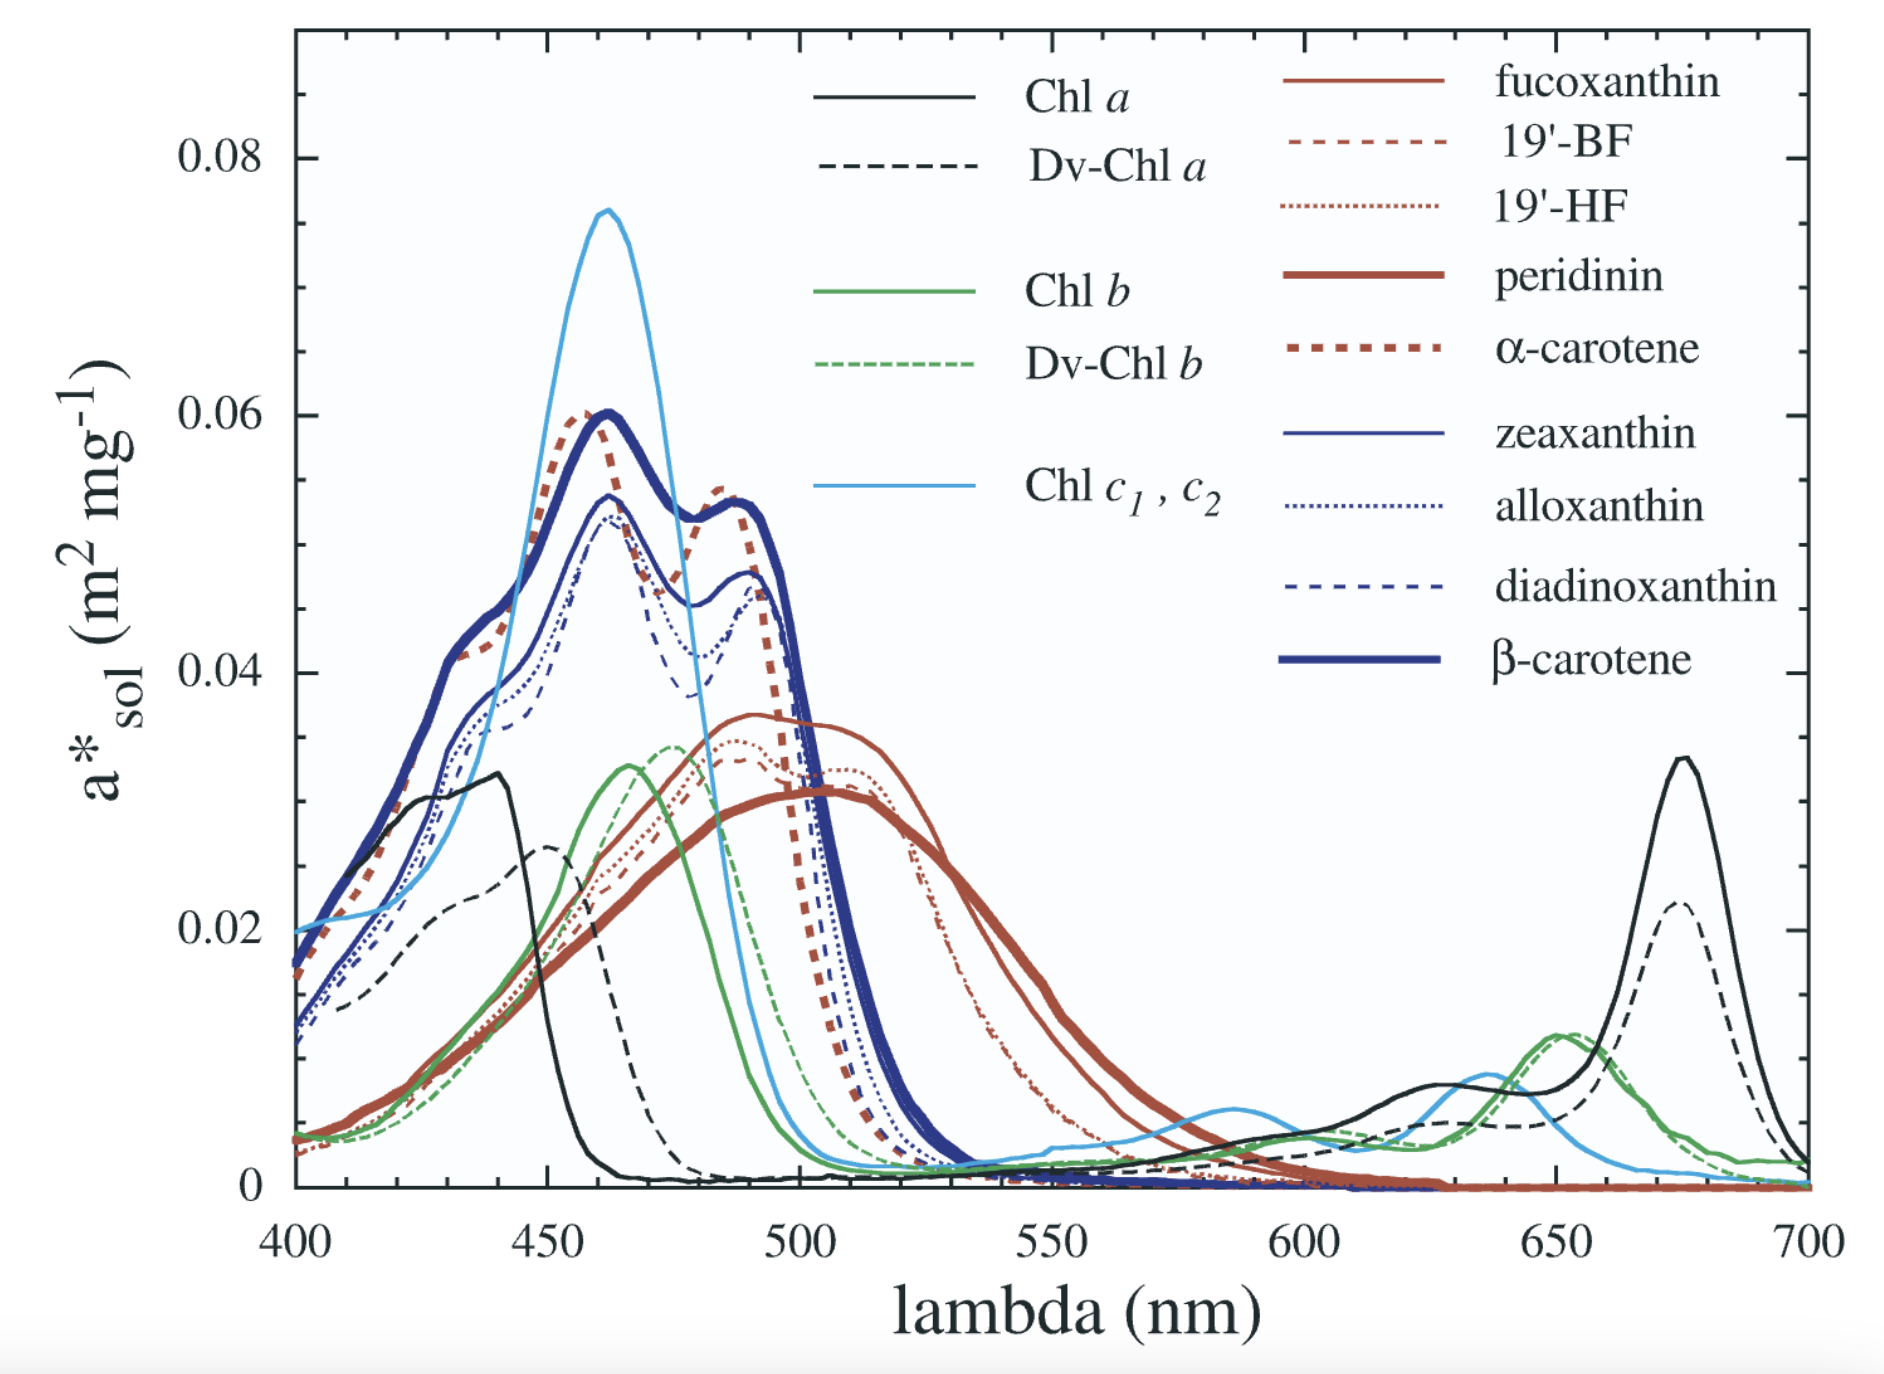